# Initialization and DB connection

In [1]:
!pwd

/Users/ofriedler/Dropbox/Work/Consultation/Manufuture/dev/manu_python


In [2]:
# PROJECT_PATH='/Users/ofriedler/Dropbox/Work/Consultation/Manufuture/dev/manu_python'
from datetime import date
from IPython.core.display_functions import display
import pandas as pd
#all tables and rows attributed to post_id
from utils.util_functions import searchPostId 
from displays import all_displays


from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

from six import StringIO
from IPython.display import Image
import pydotplus
import matplotlib.pyplot as plt

import logging

import manu_main
from model_training.pred_manufacturer_project_bid_submission import train_bid_submission_lr
from model_evaluation.evaluators import all_predictions, display_model_metrics_for_manufacturer


# Load libraries
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)
manu_main.set_logging_level(logging.INFO) #logging.INFO, logging.WARNING
today = date.today()

# All tables to all_tables_table

In [3]:
all_tables_df = manu_main.get_all_tables_df()
wp_manufacturers = all_tables_df['wp_manufacturers']
wp_quotes = all_tables_df['wp_quotes']
wp_projects = all_tables_df['wp_projects']

INFO:root:Enriching wp_quotes with: competing_manufacturers, num_candidates, is_bid_chosen 
INFO:root:Enriching wp_manufacturers with: participation_count
INFO:root:Enriching wp_manufacturers with: manufacturer_creation_date


# manufacturer-project bid-submission recommender

In [ ]:
training_data = all_tables_df['train_manufacturer_project_bid_submit']
target_feature = 'is_manuf_bid'

print("training data shape: " + str(training_data.shape))

In [6]:
# labels matrix
labels_matrix = training_data[['is_manuf_bid']].reset_index().pivot(index="post_id_manuf", columns="post_id_project", values="is_manuf_bid")

# Logistic regression

### predictions for one model - example

In [7]:
model = train_bid_submission_lr(training_data, target_feature, drop_projects=[3067])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [8]:
from model_evaluation.evaluators import pred_bid_submissions_for_project

ret_val = pred_bid_submissions_for_project(model, training_data, target_feature, project_post_id=3067)

In [9]:
ret_val[['pred_results', 'is_manuf_bid']].sort_values(by='pred_results', ascending=False)

pred_results  is_manuf_bid
post_id_project post_id_manuf                            
3067            770                0.170099             1
                5314               0.154376             0
                4753               0.154376             0
                23680              0.154376             0
                2184               0.140758             1
                23384              0.140758             0
                8183               0.120332             0
                1276               0.109811             1
                15611              0.099661             0
                1684               0.099661             0
                5011               0.062459             0
                740                0.062459             0
                790                0.062459             0
                12002              0.048313             0
                768                0.039178             0
                19776              0.039178             0
                15203              0.039178             0
                756                0.039178             0
                2194               0.039178             0
                15212              0.037908             0
                23710              0.037908             0
                15865              0.035298             0
                421                0.035298             0
                19924              0.035298             0
                19573              0.035298             0
                20636              0.035298             0
                19571              0.035298             0
                7490               0.035298             0
                15141              0.034149             0
                15189              0.034149             0
                788                0.026685             0
                774                0.026685             1
                19928              0.026685             0
                15228              0.025809             0
                20224              0.025809             0
                21576              0.021547             0
                766                0.021547             0
                742                0.021547             1
                20522              0.021547             0
                407                0.021547             0
                887                0.021547             0
                1266               0.021547             1
                15151              0.020836             0
                5007               0.016233             0
                11093              0.011660             0
                1670               0.010315             0

### Predictions for all manufacturer-project pairs, for a fixed model

In [10]:
labels_df, predictions_df = all_predictions(training_data, target_feature, model)

set_of_manufacturers = set(training_data.index.get_level_values('post_id_manuf'))
set_of_projects = set(training_data.index.get_level_values('post_id_project'))
manufacturer_to_project_predictions = pd.DataFrame(index = set_of_manufacturers) #, columns = list_of_projects
manufacturer_to_project_predictions.index.name ='post_id_manuf'

for project_post_id in set_of_projects:
    ret_val = manu_main.pred_bid_submissions_for_project(model, training_data, target_feature, project_post_id=project_post_id)
    all_manufacturers_predictions_for_project = ret_val[['pred_results']].rename(columns={'pred_results': project_post_id}).droplevel(level=0)
    manufacturer_to_project_predictions = manufacturer_to_project_predictions.join(all_manufacturers_predictions_for_project)
    # manufacturer_to_project_predictions.loc[:, project_post_id] = ret_val.loc[project_post_id, 'pred_results']


In [11]:
predictions_df

,2048,10241,22550,6167,4122,22557,18464,12331,8246,6209,20555,10317,2136,14427,18523,8287,6246,12394,6256,22657,12423,14474,22674,24732,8353,26789,2214,16560,20665,12477,18622,12485,18643,22758,2281,6380,22765,2290,4338,22772,8443,4360,12554,24862,24869,20774,20781,8497,18747,14652,26950,10574,2383,6480,4440,4450,14690,20840,18797,16751,22895,22914,4485,8588,4499,14739,27027,2456,4511,12706,14755,20907,25003,27054,25009,4530,18873,25019,2495,27075,8648,4555,22999,20953,4579,4584,18924,4589,12799,6655,4611,12804,8711,25095,4619,21006,25104,16917,25111,25117,14879,25121,14889,2611,14902,21054,6723,8773,6743,4696,19036,19041,19046,19051,19056,19061,19066,19071,19076,19081,4752,10901,17055,10934,19140,17098,6860,10969,19162,2781,17134,15092,4874,2835,8984,25391,23345,11062,15177,17238,11097,23389,25445,15215,2942,9094,11143,23443,21396,2971,15275,13236,25531,19396,9162,9176,19424,13287,5098,25580,13294,23537,7155,3067,13314,15367,13321,11274,7198,11298,7208,17448,23594,19505,9272,25658,19516,3142,5206,15446,3166,23649,11365,13413,11390,21642,25739,17553,11418,9371,19612,23706,19616,5290,15530,15533,7346,19637,1207,25786,5324,11477,21721,19680,21732,21737,21741,21745,21749,7416,23806,5375,5382,1288,15626,9493,17685,11545,17698,3368,23853,1335,1339,9533,19782,7498,25937,15704,23901,1386,7539,9588,17792,13698,7557,5510,15749,1422,23956,17818,26015,19873,11684,1449,21945,7619,3525,13767,5588,24021,26070,19933,1511,19947,11757,22010,19968,5633,7682,17923,24066,15872,3595,11796,1571,15916,3632,13884,3645,26180,20042,1611,3673,26204,24158,1644,7799,11899,22139,26238,3718,20108,24221,7840,7850,22188,16051,9911,5819,7887,24271,3801,1775,14077,12030,18184,5899,20236,22289,5910,26394,3876,12068,24377,7997,22341,16204,3918,22360,18269,12136,8042,18303,8065,22402,12161,20354,3988,10139,1953,16289,4005,22444,10160,14270,16319,6080,2006,18392,12254,18398,2019,12259,14308,24556,6128,14321,8189
post_id_manuf,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
768,0.037208,0.045554,0.030610,0.039178,0.025800,0.053844,0.029892,0.039178,0.030610,0.039178,0.039178,0.045554,0.039567,0.030610,0.029892,0.039178,0.029892,0.033999,0.029892,0.020957,0.035644,0.035146,0.024888,0.026902,0.039178,0.029009,0.039178,0.024888,0.035644,0.039567,0.022661,0.018396,0.039567,0.033999,0.030610,0.033999,0.033999,0.039178,0.034468,0.026159,0.029768,0.026902,0.033999,0.022965,0.030067,0.030067,0.030067,0.053844,0.025800,0.033999,0.033999,0.040274,0.039178,0.032728,0.033999,0.046364,0.042855,0.022661,0.037811,0.033999,0.024444,0.034668,0.033999,0.033454,0.030181,0.033999,0.039567,0.045554,0.030181,0.033260,0.030610,0.041365,0.030067,0.039567,0.022661,0.029892,0.039178,0.030067,0.026902,0.039567,0.053844,0.033999,0.033999,0.039567,0.039178,0.033999,0.039567,0.033999,0.030067,0.046364,0.039178,0.022661,0.034668,0.039567,0.029768,0.025800,0.039567,0.030610,0.033999,0.033999,0.026159,0.033999,0.030067,0.039178,0.026159,0.043975,0.020957,0.039178,0.034468,0.039178,0.023112,0.023112,0.023112,0.023112,0.023112,0.023112,0.023112,0.023112,0.023112,0.023112,0.046364,0.021857,0.039567,0.038187,0.039178,0.039567,0.025800,0.033999,0.030610,0.033999,0.039567,0.030067,0.037811,0.045554,0.039178,0.041063,0.029892,0.024888,0.026159,0.039178,0.026902,0.033999,0.034468,0.040274,0.033999,0.021857,0.039178,0.024444,0.039178,0.045554,0.046364,0.035644,0.039178,0.025800,0.039178,0.030610,0.035292,0.035644,0.034668,0.039178,0.039178,0.024888,0.034468,0.039178,0.033999,0.037811,0.039178,0.026902,0.039178,0.034468,0.025800,0.039178,0.035644,0.035644,0.045554,0.030067,0.022293,0.033999,0.053844,0.026902,0.032807,0.022977,0.040827,0.040274,0.026902,0.035644,0.022661,0.032592,0.033999,0.045554,0.030610,0.026159,0.025800,

manufacturer_id_to_view = 5011
pred_and_label = pd.concat([predictions_df.loc[[manufacturer_id_to_view,]], labels_matrix.loc[[manufacturer_id_to_view,]]])
pred_and_label.index = ['predictions', 'labels']
pred_and_label = pred_and_label.T
from matplotlib import pyplot

pyplot.hist(pred_and_label[pred_and_label['labels'] == 1]['predictions'], alpha=0.5, density=True, label='positives')
pyplot.hist(pred_and_label[pred_and_label['labels'] == 0]['predictions'], alpha=0.5, density=True, label='negatives')
pyplot.legend(loc='upper right')
pyplot.show()

fpr, tpr, _ = metrics.roc_curve(y_true=pred_and_label['labels'],y_score=pred_and_label['predictions'])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)

prec, recall, _ = metrics.precision_recall_curve(y_true=pred_and_label['labels'], probas_pred=pred_and_label['predictions'])
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()


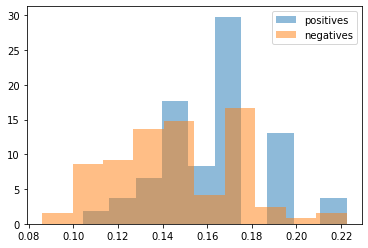

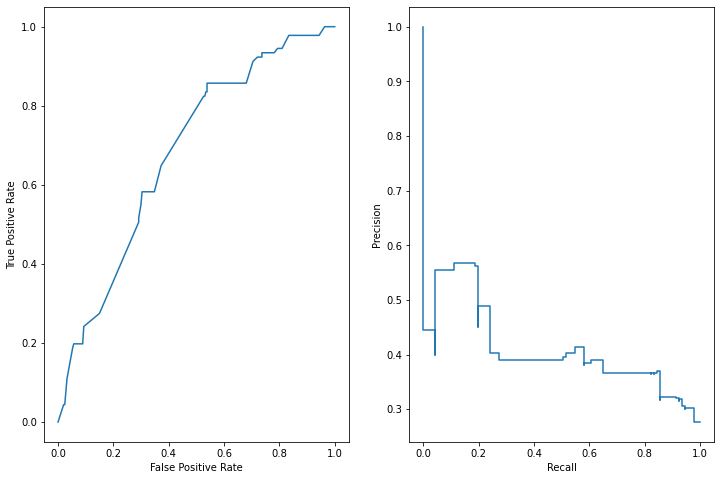

In [12]:
display_model_metrics_for_manufacturer(predictions_df, labels_matrix, 770)

Manufacturer ID: 5011


,id,post_id,vendors,street,house,city,zip,country,employees_num,irs,vat,cnc_turning,cnc_turning_min_diameter,cnc_turning_min_length,cnc_turning_max_diameter,cnc_turning_max_length,cnc_turning_machines_num,cnc_turning_notes,cnc_milling,cnc_milling_min_length,cnc_milling_min_width,cnc_milling_min_height,cnc_milling_max_length,cnc_milling_max_width,cnc_milling_max_height,cnc_milling_machines_num,cnc_milling_notes,cnc_turning_milling,cnc_turning_milling_min_diameter,cnc_turning_milling_min_length,cnc_turning_milling_max_diameter,cnc_turning_milling_max_length,cnc_turning_milling_machines_num,cnc_turning_milling_notes,conventional_turning,conventional_turning_min_diameter,conventional_turning_min_length,conventional_turning_max_diameter,conventional_turning_max_length,conventional_turning_machines_num,conventional_turning_notes,conventional_milling,conventional_milling_min_length,conventional_milling_min_width,conventional_milling_min_height,conventional_milling_max_length,conventional_milling_max_width,conventional_milling_max_height,conventional_milling_machines_num,conventional_milling_notes,sheet_metal_laser_cutting,sheet_metal_laser_cutting_min_length,sheet_metal_laser_cutting_min_width,sheet_metal_laser_cutting_min_thickness,sheet_metal_laser_cutting_max_length,sheet_metal_laser_cutting_max_width,sheet_metal_laser_cutting_max_thickness,sheet_metal_laser_cutting_machines_num,sheet_metal_laser_cutting_notes,sheet_metal_press_break,sheet_metal_press_break_min_length,sheet_metal_press_break_min_width,sheet_metal_press_break_min_thickness,sheet_metal_press_break_max_length,sheet_metal_press_break_max_width,sheet_metal_press_break_max_thickness,sheet_metal_press_break_machines_num,sheet_metal_press_break_notes,sheet_metal_punching,sheet_metal_punching_min_length,sheet_metal_punching_min_width,sheet_metal_punching_min_thickness,sheet_metal_punching_max_length,sheet_metal_punching_max_width,sheet_metal_punching_max_thickness,sheet_metal_punching_machines_num,sheet_metal_punching_notes,sheet_metal_inserts,sheet_metal_weldings,batch_size_10,batch_size_100,batch_size_1000,batch_size_9999,preffered_type_part_manufacturing,preffered_type_assemblies,preffered_type_full_turnkey,inspection_formal_inspection,inspection_cmm_inspection,inspection_first_article,disabled_group_stainless_steel,disabled_group_aluminum_alloy,disabled_group_carbon_alloy_steel,disabled_group_nickel_alloy,disabled_group_titanium_alloy,disabled_group_cooper_alloy,disabled_group_plastics,certifications,qa_lab_capability_desc,traceability_system,sqe_team_and_supplier_quality_policy,quality_system_desc,company_id,currency,international,shipping_cost,participation_count
27,43,5011,105,Gan Rave st,1,Yavne,99999,IL,6-20,,,0,None,None,None,None,None,None,1,2,2,520,1600,800,500,5,,1,1,1,150,1000,5,,0,None,None,None,None,None,None,0,None,None,None,None,None,None,None,None,0,None,None,None,None,None,None,None,None,0,None,None,None,None,None,None,None,None,0,None,None,None,None,None,None,None,None,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,[5012],,,,,512130493,ILS,0,None,67.0


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

Total number of bids: 67.0


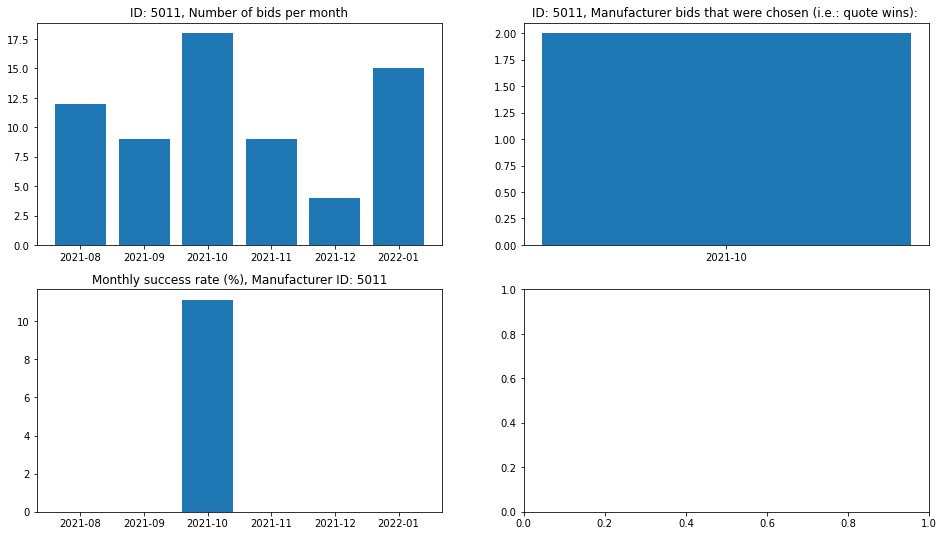

In [49]:
all_displays.manufacturer_dashboard(all_tables_df, manufacturer_id_to_view)

In [42]:
wp_manufacturers[['post_id', 'participation_count']]

,post_id,participation_count
0,182,0.0
1,407,3.0
2,421,2.0
3,740,7.0
4,742,12.0
5,756,12.0
6,766,3.0
7,768,2.0
8,770,91.0
9,774,17.0
